In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr;xr.set_options(display_style='text') 


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from tools.wrfHrTools import *
from perlmutterNotebooks.rfpreprocessing import *

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns

# Training a random forest

In [3]:
W10S300 = Simulation('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/',1635,3,out=False,pout=True)
#W10S296 = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3,'1970010100-1970090900')

In [4]:
sample_rce = make_df(W10S300,-3000,-5000,variables='tq',dt=24*8,p1=24,p2 = 13)

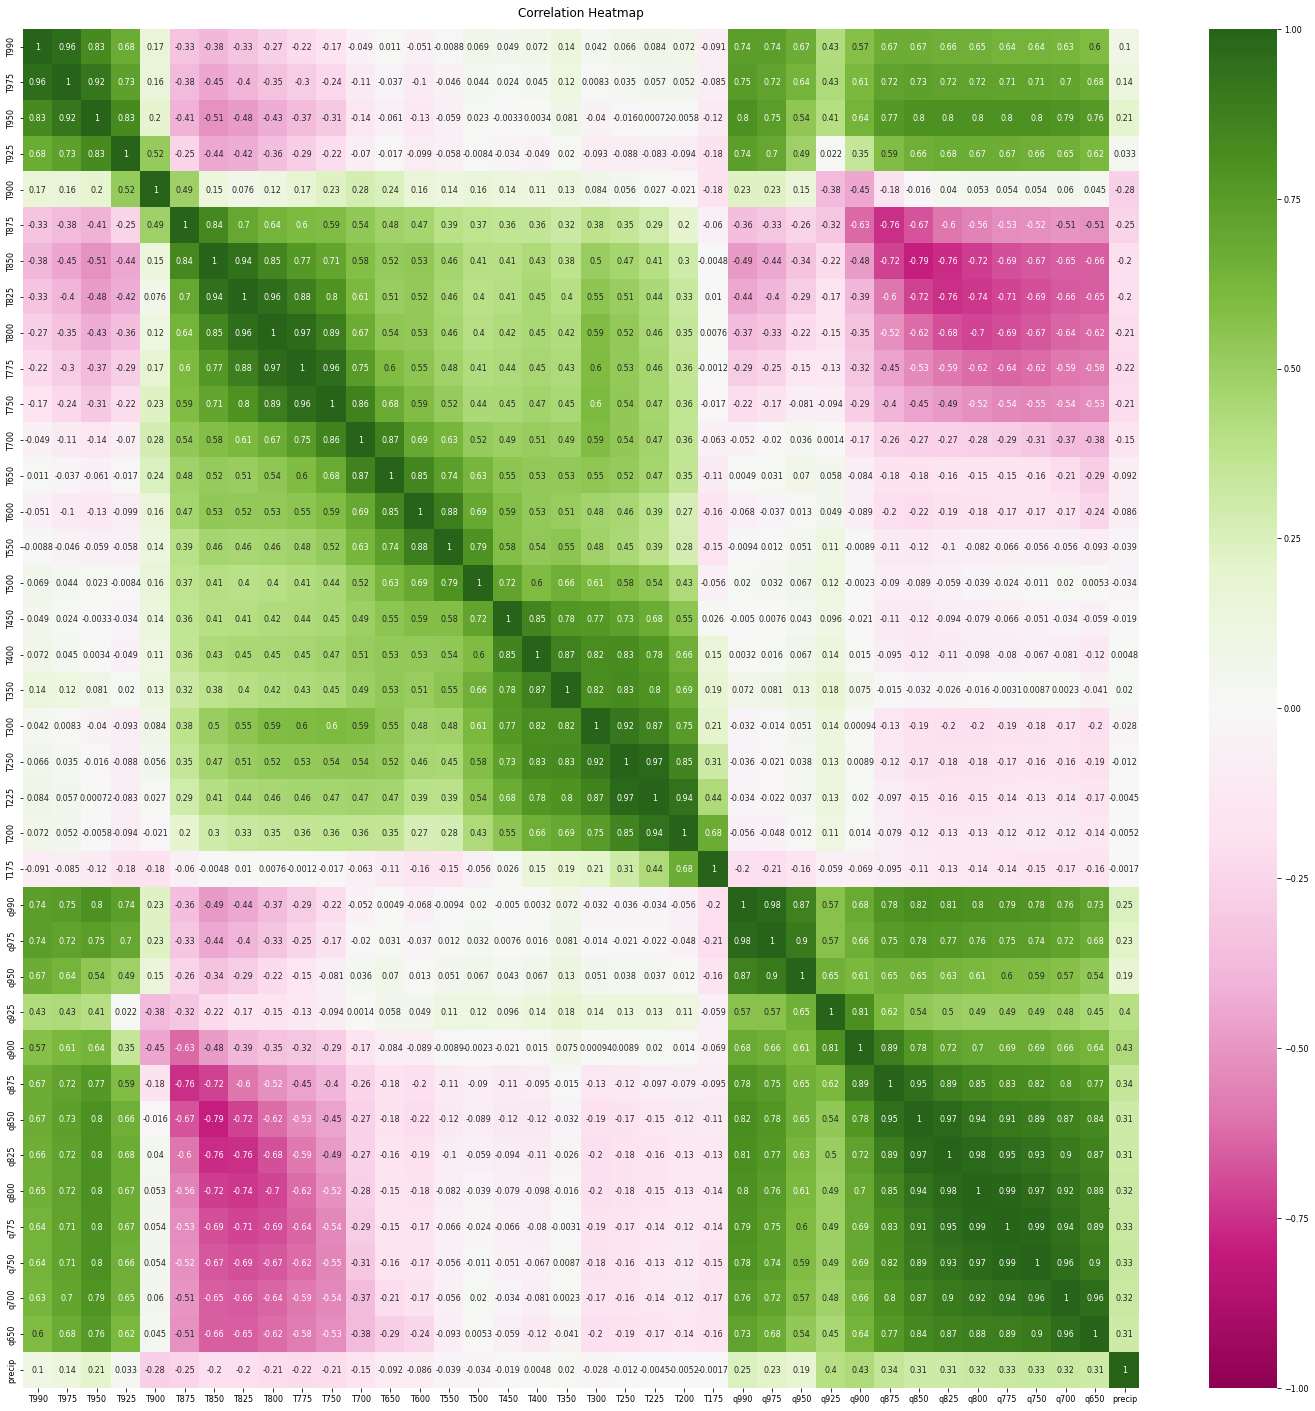

In [5]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(25, 25))

heatmap = sns.heatmap(sample_rce[:10000].corr(), vmin=-1, vmax=1, annot=True , center = 0 , cmap="PiYG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
matplotlib.rcParams.update({'font.size': 16})

In [5]:
t1 = 3000;t2 = t1+24*8
t = W10S300.datapl.T_PL[t1:t2,:-5,:,-1000:].load()
q = W10S300.datapl.Q_PL[t1:t2,:-16,:,-1000:].load()
t=t.where(t>-1)
q=q.where(q>-1)
rainnc = xr.open_zarr(W10S300.path+'wrf.SFCVARS.1h.1970010100-1970072000.zarr').RAINNC_MMDY[t1:t2,:,-1000:].load()
rainncv = xr.open_zarr(W10S300.path+'wrf.SFCVARS.1h.1970010100-1970072000.zarr').RAINNCV_MMDY[t1:t2,:,-1000:].load()

In [6]:
BL = xr.open_zarr(W10S300.path+'wrf.BL_DEEP.1h.1970010100-1970072000.zarr').B_L[t1:t2,:,-1000:].load()


In [7]:
#t = t.coarsen(num_press_levels_stag=3).mean()
#q = q.coarsen(num_press_levels_stag=3).mean()

In [8]:
def to_ar(var):
    n = len(var.num_press_levels_stag)
    return var.transpose('num_press_levels_stag','Time','south_north','west_east').data.reshape((n,-1))

In [9]:
features_ar = np.concatenate((to_ar(t),to_ar(q)),axis=0).T

outputs_ar = rainnc.data.reshape(-1)
#outputs_ar = rainncv.data.reshape(-1)

BL_ar = BL.data.reshape(-1)

idx = ~np.isnan(features_ar[:,0])
features_ar = features_ar[idx]
outputs_ar  = outputs_ar [idx]
BL_ar = BL_ar[idx]

In [10]:
d1 = {i:"T%i"%(plevs[i]/100) for i in range(24)} 
d2 = {i+24:"q%i"%(plevs[i]/100) for i in range(17)}
featurenames = {**d1,**d2}

In [11]:
outputs_df = pd.DataFrame(outputs_ar)
outputs_df = outputs_df.rename(columns={0:'precip'})

features_df = pd.DataFrame(features_ar).rename(columns=featurenames)#[:300000]

In [38]:
#breakpoints = [j*0.1 for j in range(10)]+[j*10**i for i in range(-1,3) for j in range(10,100)]
breakpoints = [0.]+list(10**np.linspace(-1,4,301))
samples_per_bin=3000

all_df = pd.concat([features_df,outputs_df],axis=1)
all_df['bins'] = pd.cut(outputs_df['precip'],breakpoints,right=False,labels=breakpoints[:-1])

all_df_sampled = all_df.groupby('bins').apply(lambda x: x.sample(min(samples_per_bin,len(x))).reset_index(drop=True))

all_df_sampled = all_df_sampled.drop('bins',axis=1).reset_index().drop('bins',axis=1).drop('level_1',axis=1)

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(features_df,outputs_df['precip'],test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(sample_rce.drop('precip',axis=1),sample_rce['precip'],test_size=0.2)




In [7]:
%%time
rf = RandomForestRegressor(max_features=20 ,n_estimators = 10,verbose=True , min_samples_leaf= 20,n_jobs=10, min_samples_split = 5)
rf.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   12.5s remaining:   50.1s


CPU times: user 2min 9s, sys: 43 ms, total: 2min 9s
Wall time: 13.5 s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   13.5s finished


RandomForestRegressor(max_features=20, min_samples_leaf=20, min_samples_split=5,
                      n_estimators=10, n_jobs=10, verbose=True)

In [39]:
#%%time
#gdb = GradientBoostingRegressor(max_features=5 ,n_estimators = 100)
#gdb.fit(X_train, y_train)


CPU times: user 1min 48s, sys: 15.3 ms, total: 1min 48s
Wall time: 1min 48s


GradientBoostingRegressor(max_features=5)

In [8]:
pred = rf.predict(X_test)
print('MAE: ',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error( y_test, pred))

MAE:  37.172936099738195
MSE:  3796.564825495664


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [44]:
pred = gdb.predict(X_test)
print('MAE: ',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error( y_test, pred))

MAE:  45.50932519735891
MSE:  5381.925245991029


In [9]:
importances = list(rf.feature_importances_)
feature_list = list(X_test.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

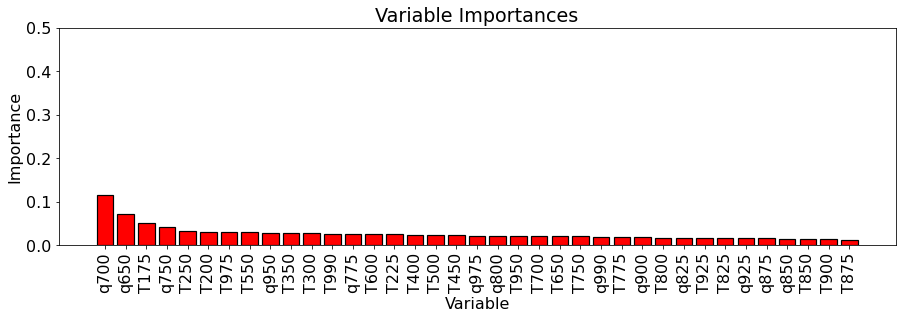

In [10]:
#plot the feature importance 
plt.figure(figsize=(15,4))
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, sorted(importances , reverse = True), orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2 )
# Tick labels for x axis
plt.xticks(x_values, list(np.array(feature_importances)[:,0]), rotation='vertical')
plt.ylim((0,0.5))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Testing accuracy vs B_L

In [18]:
from scipy.optimize import curve_fit
func = lambda x,a,b : np.exp(a*x+b)


[25.09935669  2.21202133]


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(-1.0, 100.0)

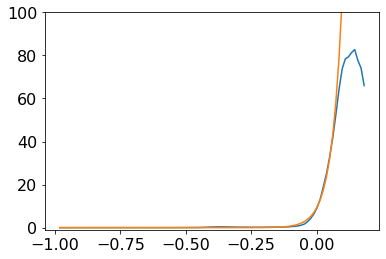

In [55]:
bl_rce,pr_rce = get_blpr(W10S300,-3000,-5000,t1=4000,dt=24*4)
c,m = get_binned(bl_rce,pr_rce,np.linspace(-1,0.2,101))
idx = ~np.isnan(m)
c=c[idx];m=m[idx]

n=88
popt,_ = curve_fit(func,c[:n],m[:n])
print(popt)
fit = lambda x : np.exp(popt[0]*x+popt[1])

plt.plot(c,m)
plt.plot(c,fit(c))
plt.ylim(-1,100)

[18.39143192  2.45275637]


(-1.0, 100.0)

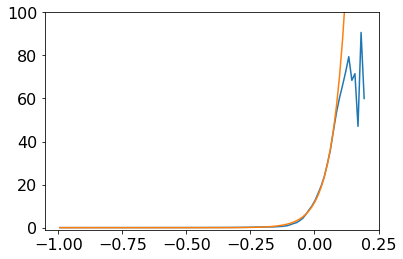

In [43]:
bl_rce,pr_rce = get_blpr(W10S300,-3000,-5000,t1=4000,dt=24*4,bltype='700_900')
c,m = get_binned(bl_rce,pr_rce,np.linspace(-1,0.2,101))
idx = ~np.isnan(m)
c=c[idx];m=m[idx]

n=90
poptsh,_ = curve_fit(func,c[:n],m[:n])
print(poptsh)
fitsh = lambda x : np.exp(poptsh[0]*x+poptsh[1])

plt.plot(c,m)
plt.plot(c,fitsh(c))
plt.ylim(-1,100)

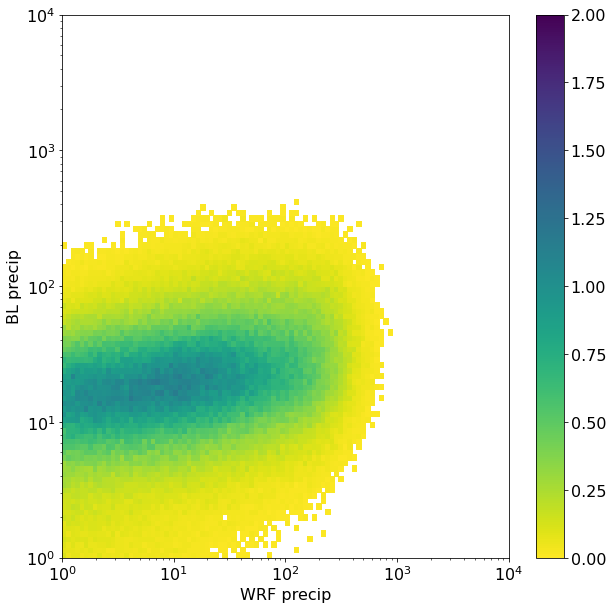

In [56]:
plt.figure(figsize=(10,10))
#plt.scatter(pred,y_test)
bins_pr = 10**np.linspace(0,4,101)
a=plt.hist2d(pr_rce,fit(bl_rce), bins=[bins_pr,bins_pr],weights = 1e4*pr_rce**0/len(pr_rce),cmap=plt.cm.viridis_r,cmin = 0.01,vmin=0,vmax=2.)#, cmin=10)
plt.colorbar(a[3])     
plt.xscale('log');plt.yscale('log')
plt.xlabel('WRF precip'); plt.ylabel('BL precip'); 

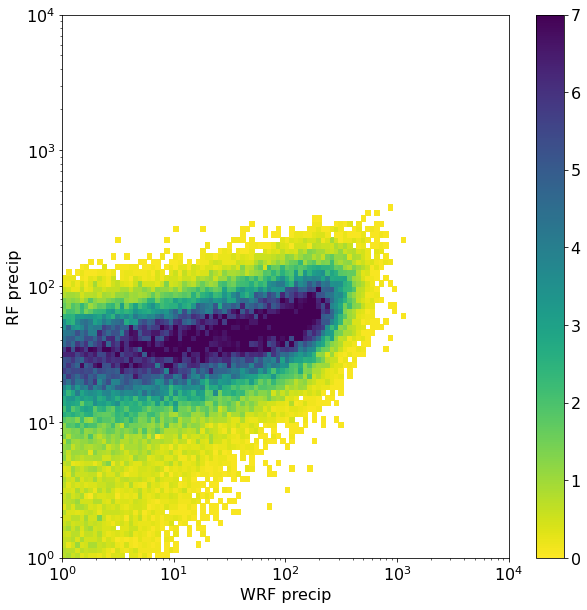

In [57]:
plt.figure(figsize=(10,10))
#plt.scatter(pred,y_test)
bins_pr = 10**np.linspace(0,4,101)
a=plt.hist2d(y_test,pred, bins=[bins_pr,bins_pr],weights = 1e4*y_test**0/len(y_test),cmap=plt.cm.viridis_r,cmin = 0.01,vmin=0,vmax=7.)#, cmin=10)
plt.colorbar(a[3])     
plt.xscale('log')
plt.yscale('log')
plt.xlabel('WRF precip'); plt.ylabel('RF precip'); 

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')


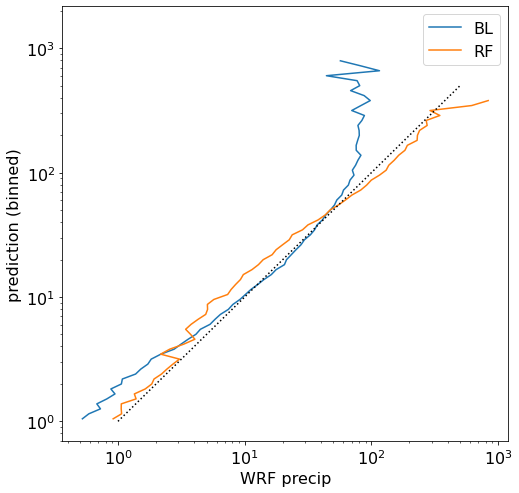

In [20]:
plot_1to1([(fit(bl_rce),pr_rce,'BL'),(pred,y_test,'RF')],log=True)

# Split RCE / mountain / downstream

In [25]:
test_mtn = make_df(W10S300,-100,-400  ,t1=4000,dt=24*4,variables='tq',p1=24,p2 = 13)
test_lee = make_df(W10S300,800,200    ,t1=4000,dt=24*4,variables='tq',p1=24,p2 = 13)

pred_rce = pred
pred_mtn = rf.predict(test_mtn.drop('precip',axis=1))
pred_lee = rf.predict(test_lee.drop('precip',axis=1))
true_rce = y_test
true_mtn = test_mtn['precip']
true_lee = test_lee['precip']

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [48]:
bl_rce,pr_rce = get_blpr(W10S300,-4000,-4300,t1=4000,dt=24*4)
bl_mtn,pr_mtn = get_blpr(W10S300,-100,-400  ,t1=4000,dt=24*4)
bl_lee,pr_lee = get_blpr(W10S300,800,200    ,t1=4000,dt=24*4)

In [49]:
blsh_rce,_ = get_blpr(W10S300,-4000,-4300,t1=4000,dt=24*4,bltype='700_900')
blsh_mtn,_ = get_blpr(W10S300,-100,-400  ,t1=4000,dt=24*4,bltype='700_900')
blsh_lee,_ = get_blpr(W10S300,800,200    ,t1=4000,dt=24*4,bltype='700_900')

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')


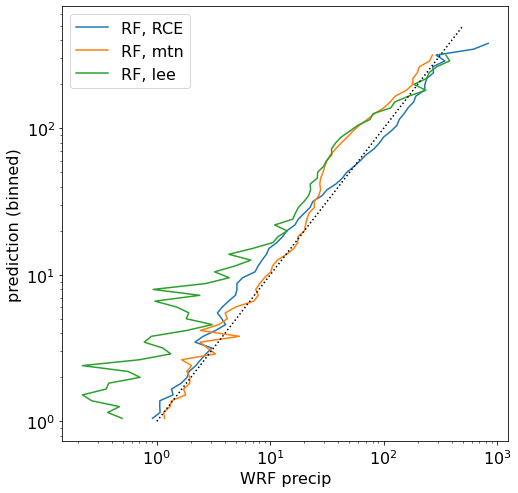

In [31]:
plot_1to1([(pred_rce,true_rce,'RF, RCE'),(pred_mtn,true_mtn,'RF, mtn'),(pred_lee,true_lee,'RF, lee')],log=True)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


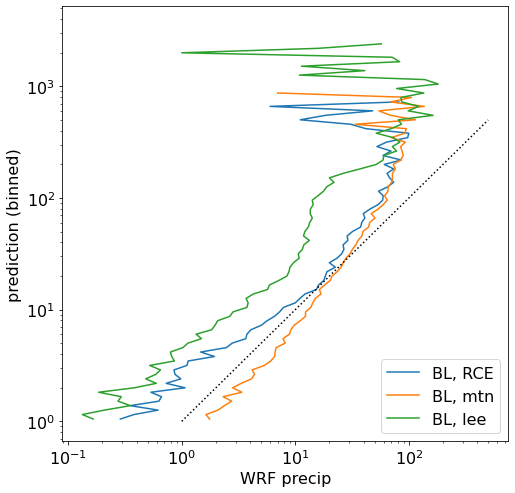

In [53]:
plot_1to1([(fit(bl_rce),pr_rce,'BL, RCE'),
           (fit(bl_mtn),pr_mtn,'BL, mtn'),
           (fit(bl_lee),pr_lee,'BL, lee')
          ],log=True)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


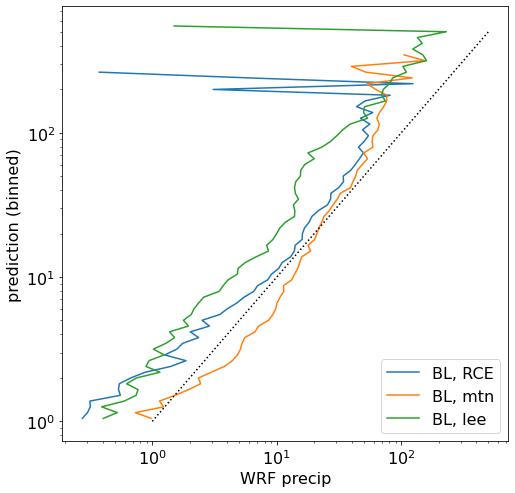

In [52]:
plot_1to1([(fitsh(blsh_rce),pr_rce,'BL, RCE'),
           (fitsh(blsh_mtn),pr_mtn,'BL, mtn'),
           (fitsh(blsh_lee),pr_lee,'BL, lee')
          ],log=True)